In [1]:
import pickle
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

### Loading the Data

In [2]:
def unpickle(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')

    images = batch[b'data']
    labels = batch[b'labels']

    return images, labels

def preprocess_cifar(images, labels):
    images = images.reshape(-1, 3, 32, 32)
    images = images.transpose(0, 2, 3, 1)  # CHW → HWC
    images = images.astype("float32") / 255.0

    labels = np.array(labels, dtype="int64")

    return images, labels

def load_cifar10_data(cifar_dir):
    x_train, y_train = [], []

    for i in range(1, 6):
        images, labels = unpickle(
            os.path.join(cifar_dir, f"data_batch_{i}")
        )
        images, labels = preprocess_cifar(images, labels)
        x_train.append(images)
        y_train.append(labels)

    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)

    x_test, y_test = unpickle(
        os.path.join(cifar_dir, "test_batch")
    )
    x_test, y_test = preprocess_cifar(x_test, y_test)

    return (x_train, y_train), (x_test, y_test)

In [3]:
data_directory = 'cifar-10-batches-py'
(X, y), (X_test, y_test) = load_cifar10_data(data_directory)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000,)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


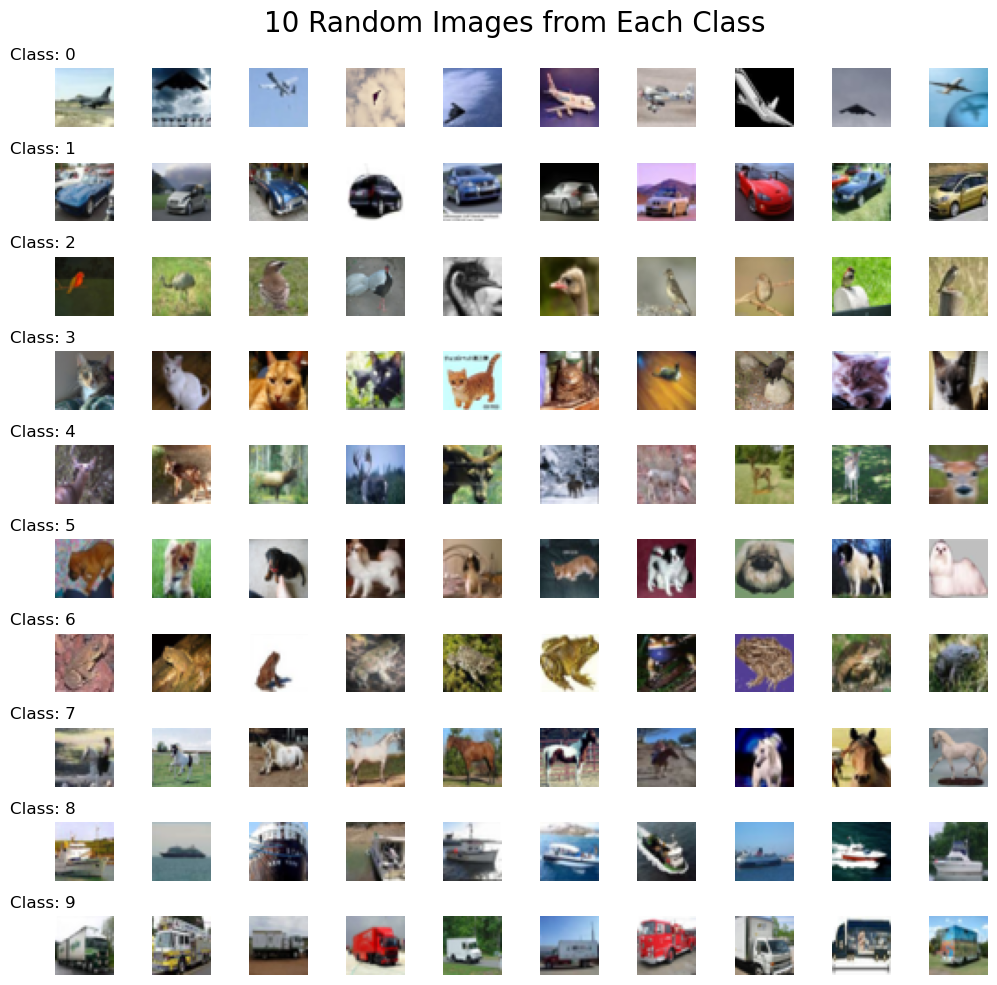

In [4]:
class_indices = [np.where(y_train == i)[0] for i in range(10)]
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
class_names = [str(i) for i in range(10)]
for i in range(10):
    random_indices = np.random.choice(class_indices[i], 10, replace=False)
    for j in range(10):
        idx = random_indices[j]
        img = X_train[idx]
            
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')

        if j == 0:
            ax.set_title(f"Class: {class_names[i]}", x=-0.2)

plt.suptitle("10 Random Images from Each Class", fontsize=20)
plt.tight_layout()
plt.show()

### CNN Architecture

In [5]:
def create_cnn(
    activation_fn,
    initializer,
    optimizer_str,
    input_shape=(32, 32, 3),
    num_classes=10,
    fc_size=256,
    dropout_val=0.5
):
    def activate(x, activation_fn):
        if activation_fn == 'leaky_relu':
            return layers.LeakyReLU(alpha=0.01)(x)
        else:
            return layers.Activation(activation_fn)(x)

    optimizers_map = {
        'adam': optimizers.Adam(),
        'sgd': optimizers.SGD(),
        'rmsprop': optimizers.RMSprop()
    }
    optimizer = optimizers_map[optimizer_str.lower()]

    model_input = layers.Input(shape=input_shape)
    x = model_input

    x = layers.Conv2D(16, (3, 3), padding='same', kernel_initializer=initializer)(x)
    x = activate(x, activation_fn)
    x = layers.Conv2D(16, (3, 3), padding='same', kernel_initializer=initializer)(x)
    x = activate(x, activation_fn)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_val)(x)

    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer)(x)
    x = activate(x, activation_fn)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer)(x)
    x = activate(x, activation_fn)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_val)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer)(x)
    x = activate(x, activation_fn)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer)(x)
    x = activate(x, activation_fn)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_val)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(fc_size, kernel_initializer=initializer)(x)
    x = activate(x, activation_fn)

    model_output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

### Training Configuration

In [6]:
def train_cnn(model, x_train, y_train, x_val, y_val, model_name, epochs=100, batch_size=100):
    print(f"--- Training {model_name} ---")
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    total_time = time.time() - start_time
    
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Total training time: {total_time:.2f} seconds")
    model.save(f"{model_name}.keras")
    return history
    
def plot_history(history, title):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'{title} Train Acc')
    plt.plot(history.history['val_accuracy'], label=f'{title} Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'{title} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{title} Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

### Training the Different 27 Models

--- Training MCifar_relu_xavier_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1138 - loss: 2.2955 - val_accuracy: 0.1437 - val_loss: 2.2917
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1698 - loss: 2.2154 - val_accuracy: 0.2420 - val_loss: 2.1473
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2280 - loss: 2.1089 - val_accuracy: 0.2085 - val_loss: 2.1499
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2434 - loss: 2.0521 - val_accuracy: 0.2667 - val_loss: 2.0341
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2495 - loss: 2.0160 - val_accuracy: 0.2341 - val_loss: 2.0907
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2631 - loss: 1.9770 - val_accuracy: 0.2796 - val_loss: 1.9197
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2776 - loss: 1.9371 - val_accuracy: 0.3040 - val_loss: 1.8778
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/s

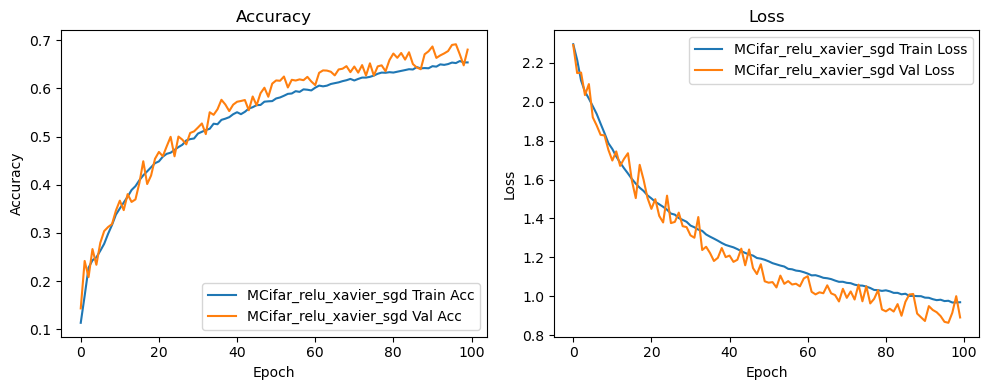

In [54]:
model_name = "MCifar_relu_xavier_sgd"
model = create_cnn(activation_fn='relu', initializer='glorot_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_xavier_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3062 - loss: 1.8677 - val_accuracy: 0.4294 - val_loss: 1.5576
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4457 - loss: 1.5039 - val_accuracy: 0.4832 - val_loss: 1.4236
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5009 - loss: 1.3664 - val_accuracy: 0.5313 - val_loss: 1.2922
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5339 - loss: 1.2848 - val_accuracy: 0.5721 - val_loss: 1.1831
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5627 - loss: 1.2201 - val_accuracy: 0.5699 - val_loss: 1.2027
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5759 - loss: 1.1743 - val_accuracy: 0.6098 - val_loss: 1.0825
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5988 - loss: 1.1243 - val_accuracy: 0.6341 - val_loss: 1.0258
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms

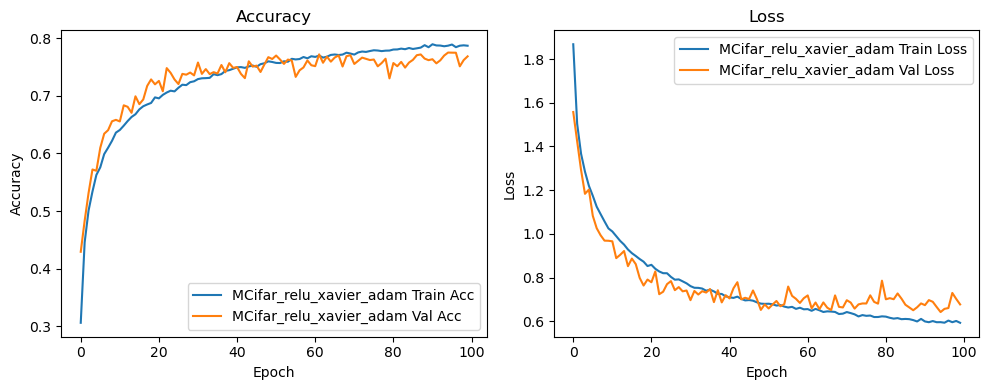

In [55]:
model_name = "MCifar_relu_xavier_adam"
model = create_cnn(activation_fn='relu', initializer='glorot_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_xavier_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.2758 - loss: 1.9737 - val_accuracy: 0.3831 - val_loss: 1.7391
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3895 - loss: 1.6687 - val_accuracy: 0.4312 - val_loss: 1.5432
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4467 - loss: 1.5171 - val_accuracy: 0.4862 - val_loss: 1.4247
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4892 - loss: 1.4071 - val_accuracy: 0.5550 - val_loss: 1.2315
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5230 - loss: 1.3160 - val_accuracy: 0.5950 - val_loss: 1.1362
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5520 - loss: 1.2543 - val_accuracy: 0.6053 - val_loss: 1.1040
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5728 - loss: 1.1988 - val_accuracy: 0.6172 - val_loss: 1.0687
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21

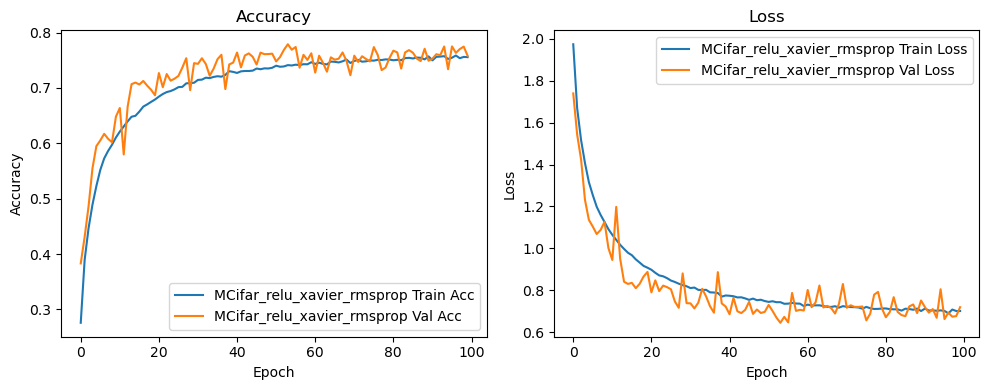

In [56]:
model_name = "MCifar_relu_xavier_rmsprop"
model = create_cnn(activation_fn='relu', initializer='glorot_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_kaiming_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1391 - loss: 2.2760 - val_accuracy: 0.1734 - val_loss: 2.2497
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2166 - loss: 2.1122 - val_accuracy: 0.2333 - val_loss: 2.0607
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2503 - loss: 1.9952 - val_accuracy: 0.2444 - val_loss: 1.9979
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2872 - loss: 1.8970 - val_accuracy: 0.2624 - val_loss: 1.9666
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3185 - loss: 1.8146 - val_accuracy: 0.3097 - val_loss: 1.8268
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3354 - loss: 1.7647 - val_accuracy: 0.3336 - val_loss: 1.7717
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3535 - loss: 1.7279 - val_accuracy: 0.2873 - val_loss: 1.9304
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/

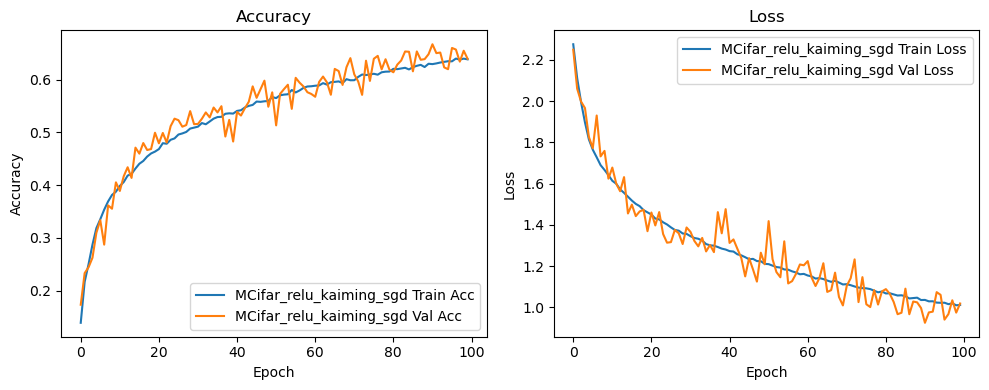

In [57]:
model_name = "MCifar_relu_kaiming_sgd"
model = create_cnn(activation_fn='relu', initializer='he_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_kaiming_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2126 - loss: 2.1315 - val_accuracy: 0.3706 - val_loss: 1.7652
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3717 - loss: 1.6879 - val_accuracy: 0.4376 - val_loss: 1.5166
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4399 - loss: 1.5208 - val_accuracy: 0.4883 - val_loss: 1.4124
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4825 - loss: 1.4219 - val_accuracy: 0.5217 - val_loss: 1.3112
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5133 - loss: 1.3421 - val_accuracy: 0.5609 - val_loss: 1.2150
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5369 - loss: 1.2794 - val_accuracy: 0.6014 - val_loss: 1.1184
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5593 - loss: 1.2271 - val_accuracy: 0.5969 - val_loss: 1.1381
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19m

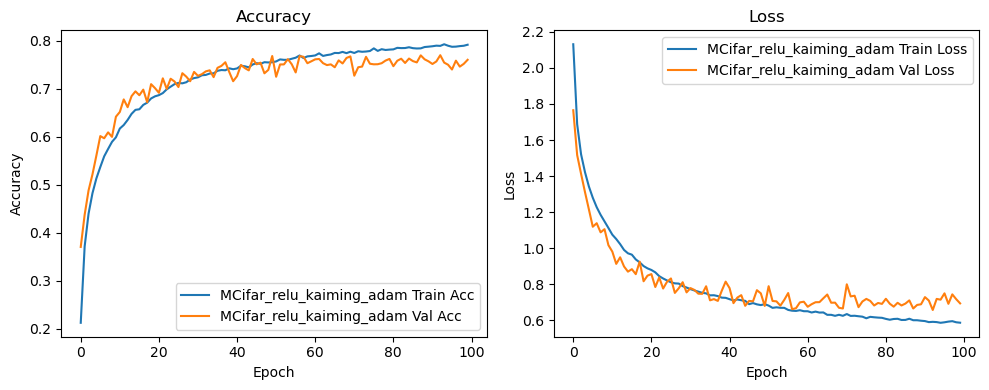

In [82]:
model_name = "MCifar_relu_kaiming_adam"
model = create_cnn(activation_fn='relu', initializer='he_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_kaiming_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2621 - loss: 2.0176 - val_accuracy: 0.3807 - val_loss: 1.7128
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3808 - loss: 1.6830 - val_accuracy: 0.4543 - val_loss: 1.5249
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4356 - loss: 1.5415 - val_accuracy: 0.5047 - val_loss: 1.3666
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4732 - loss: 1.4459 - val_accuracy: 0.5358 - val_loss: 1.3012
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5051 - loss: 1.3673 - val_accuracy: 0.5366 - val_loss: 1.2961
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5266 - loss: 1.3053 - val_accuracy: 0.5734 - val_loss: 1.1920
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5515 - loss: 1.2537 - val_accuracy: 0.5510 - val_loss: 1.2469
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 2

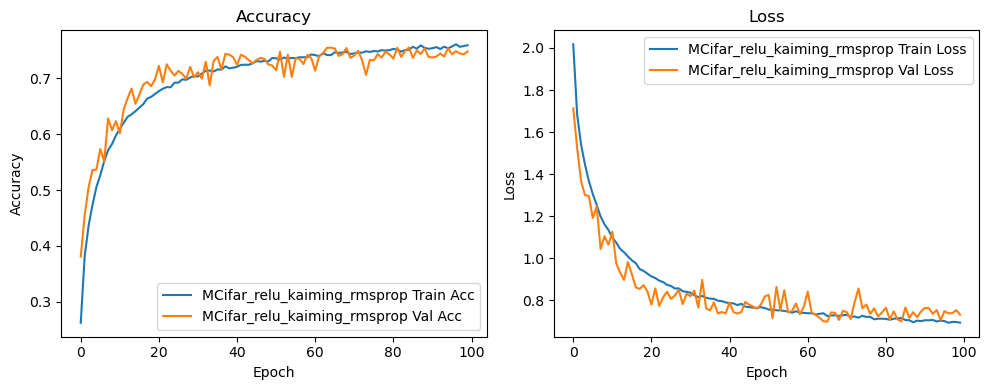

In [59]:
model_name = "MCifar_relu_kaiming_rmsprop"
model = create_cnn(activation_fn='relu', initializer='he_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_random_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1065 - loss: 2.3017 - val_accuracy: 0.1534 - val_loss: 2.3003
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1370 - loss: 2.2886 - val_accuracy: 0.1656 - val_loss: 2.2670
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1854 - loss: 2.1955 - val_accuracy: 0.2163 - val_loss: 2.1703
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2268 - loss: 2.1064 - val_accuracy: 0.2599 - val_loss: 2.0437
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2390 - loss: 2.0501 - val_accuracy: 0.2732 - val_loss: 1.9904
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2496 - loss: 2.0163 - val_accuracy: 0.2685 - val_loss: 1.9680
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2600 - loss: 1.9839 - val_accuracy: 0.2777 - val_loss: 1.9231
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/s

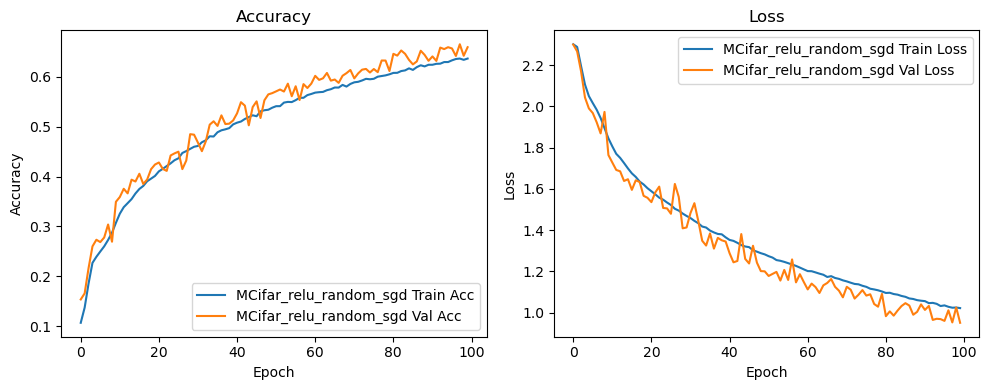

In [60]:
model_name = "MCifar_relu_random_sgd"
model = create_cnn(activation_fn='relu', initializer='random_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_random_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2696 - loss: 1.9579 - val_accuracy: 0.3606 - val_loss: 1.6923
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3989 - loss: 1.6216 - val_accuracy: 0.4516 - val_loss: 1.5207
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4580 - loss: 1.4683 - val_accuracy: 0.5176 - val_loss: 1.3354
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4939 - loss: 1.3822 - val_accuracy: 0.4964 - val_loss: 1.3952
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5246 - loss: 1.3130 - val_accuracy: 0.5138 - val_loss: 1.3628
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5411 - loss: 1.2621 - val_accuracy: 0.5333 - val_loss: 1.3076
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5600 - loss: 1.2162 - val_accuracy: 0.5031 - val_loss: 1.4681
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms

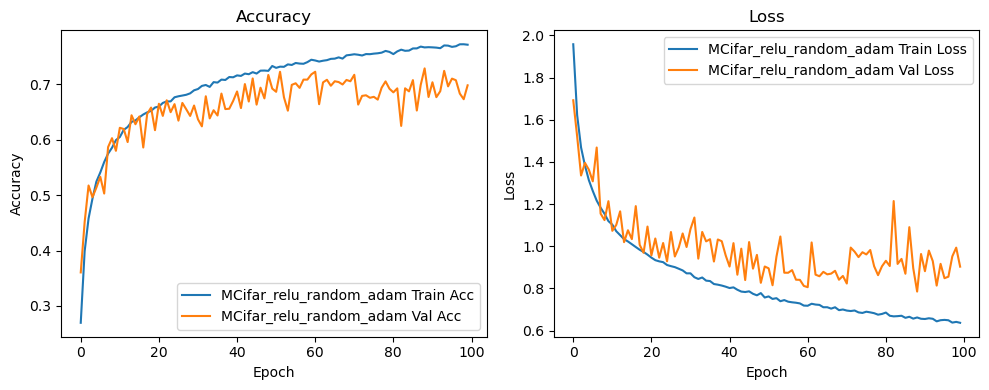

In [61]:
model_name = "MCifar_relu_random_adam"
model = create_cnn(activation_fn='relu', initializer='random_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_relu_random_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.2389 - loss: 2.0400 - val_accuracy: 0.3434 - val_loss: 1.7746
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3592 - loss: 1.7289 - val_accuracy: 0.4074 - val_loss: 1.6154
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4229 - loss: 1.5695 - val_accuracy: 0.4684 - val_loss: 1.4596
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4626 - loss: 1.4687 - val_accuracy: 0.5022 - val_loss: 1.3789
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4920 - loss: 1.3996 - val_accuracy: 0.5416 - val_loss: 1.2865
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5195 - loss: 1.3304 - val_accuracy: 0.5429 - val_loss: 1.2736
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5400 - loss: 1.2742 - val_accuracy: 0.5819 - val_loss: 1.1622
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 2

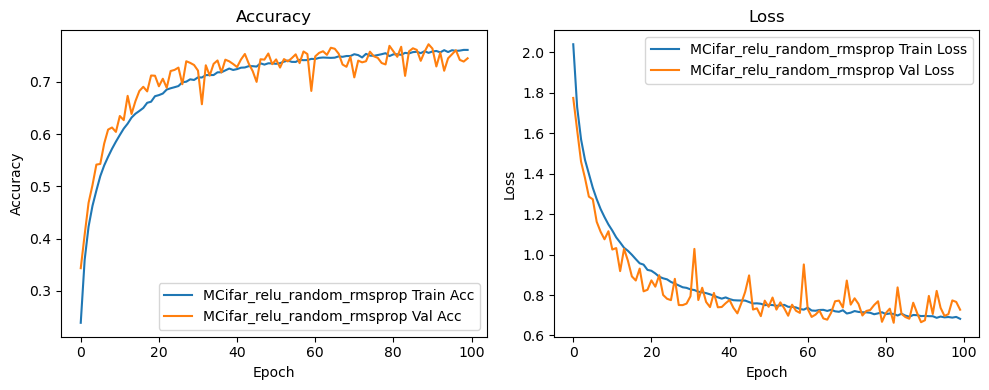

In [62]:
model_name = "MCifar_relu_random_rmsprop"
model = create_cnn(activation_fn='relu', initializer='random_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_xavier_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1811 - loss: 2.1835 - val_accuracy: 0.2474 - val_loss: 2.0107
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2932 - loss: 1.9302 - val_accuracy: 0.3354 - val_loss: 1.8044
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3557 - loss: 1.7652 - val_accuracy: 0.3206 - val_loss: 1.8468
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3880 - loss: 1.6747 - val_accuracy: 0.2554 - val_loss: 2.1286
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4138 - loss: 1.6180 - val_accuracy: 0.3233 - val_loss: 1.8870
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4272 - loss: 1.5791 - val_accuracy: 0.3189 - val_loss: 1.9231
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4394 - loss: 1.5439 - val_accuracy: 0.3847 - val_loss: 1.7157
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/s

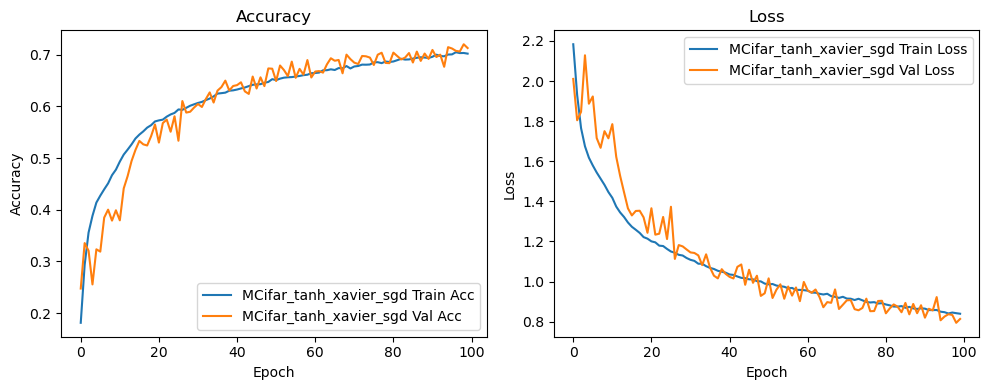

In [63]:
model_name = "MCifar_tanh_xavier_sgd"
model = create_cnn(activation_fn='tanh', initializer='glorot_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_xavier_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3833 - loss: 1.7038 - val_accuracy: 0.4586 - val_loss: 1.4870
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4971 - loss: 1.4063 - val_accuracy: 0.5206 - val_loss: 1.3429
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5540 - loss: 1.2627 - val_accuracy: 0.5887 - val_loss: 1.1761
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5862 - loss: 1.1730 - val_accuracy: 0.5781 - val_loss: 1.1926
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6059 - loss: 1.1094 - val_accuracy: 0.6415 - val_loss: 1.0064
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6226 - loss: 1.0672 - val_accuracy: 0.6429 - val_loss: 1.0244
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6399 - loss: 1.0280 - val_accuracy: 0.6517 - val_loss: 0.9792
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms

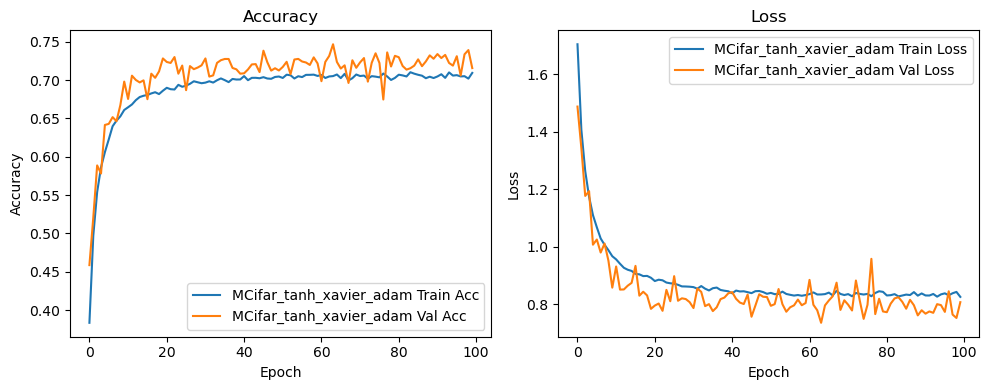

In [64]:
model_name = "MCifar_tanh_xavier_adam"
model = create_cnn(activation_fn='tanh', initializer='glorot_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_xavier_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3530 - loss: 1.7947 - val_accuracy: 0.4322 - val_loss: 1.5887
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4775 - loss: 1.4643 - val_accuracy: 0.5271 - val_loss: 1.3411
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5351 - loss: 1.3108 - val_accuracy: 0.5768 - val_loss: 1.2077
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5691 - loss: 1.2228 - val_accuracy: 0.5868 - val_loss: 1.1792
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5945 - loss: 1.1587 - val_accuracy: 0.6475 - val_loss: 1.0141
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6125 - loss: 1.1094 - val_accuracy: 0.6653 - val_loss: 0.9644
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6241 - loss: 1.0717 - val_accuracy: 0.6474 - val_loss: 1.0161
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22

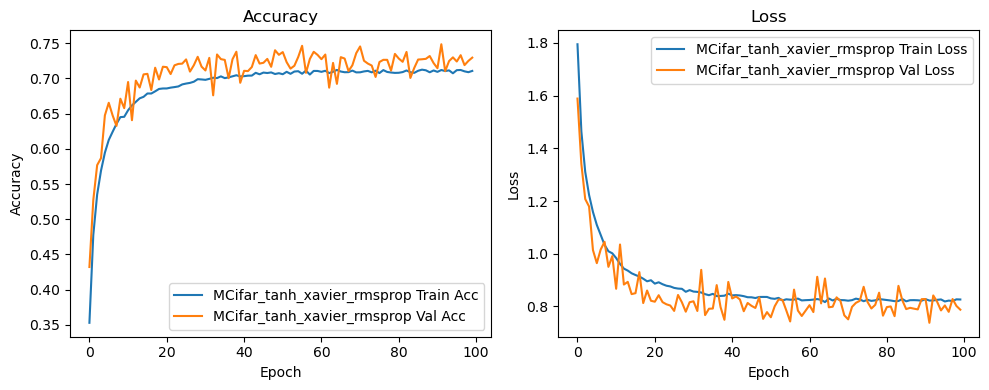

In [65]:
model_name = "MCifar_tanh_xavier_rmsprop"
model = create_cnn(activation_fn='tanh', initializer='glorot_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_kaiming_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1447 - loss: 2.3674 - val_accuracy: 0.2217 - val_loss: 2.1910
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2598 - loss: 2.0034 - val_accuracy: 0.2583 - val_loss: 2.2321
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3291 - loss: 1.8357 - val_accuracy: 0.3764 - val_loss: 1.7856
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3640 - loss: 1.7330 - val_accuracy: 0.3337 - val_loss: 1.9944
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3917 - loss: 1.6603 - val_accuracy: 0.3058 - val_loss: 2.2022
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4094 - loss: 1.6132 - val_accuracy: 0.3405 - val_loss: 1.9872
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4254 - loss: 1.5661 - val_accuracy: 0.3698 - val_loss: 1.8896
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/

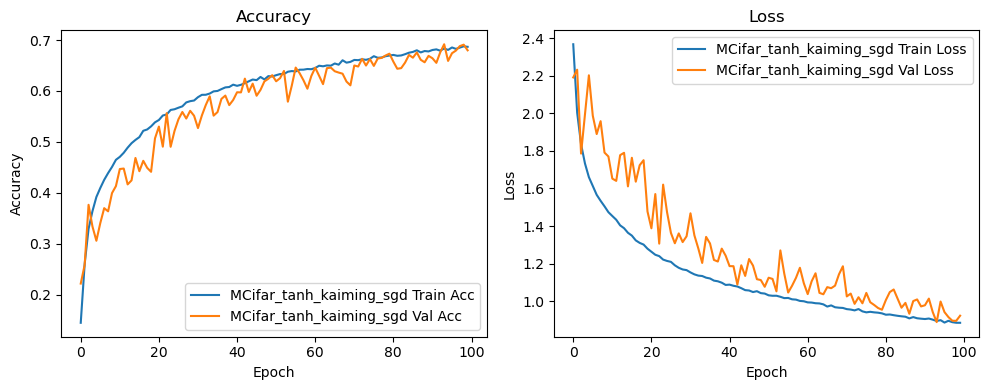

In [66]:
model_name = "MCifar_tanh_kaiming_sgd"
model = create_cnn(activation_fn='tanh', initializer='he_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_kaiming_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2621 - loss: 1.9983 - val_accuracy: 0.4210 - val_loss: 1.6253
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4348 - loss: 1.5443 - val_accuracy: 0.4566 - val_loss: 1.5133
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4909 - loss: 1.3968 - val_accuracy: 0.5274 - val_loss: 1.3469
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5294 - loss: 1.3133 - val_accuracy: 0.5801 - val_loss: 1.1797
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5491 - loss: 1.2551 - val_accuracy: 0.5697 - val_loss: 1.2079
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5677 - loss: 1.2028 - val_accuracy: 0.5938 - val_loss: 1.1483
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5820 - loss: 1.1669 - val_accuracy: 0.6301 - val_loss: 1.0421
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20m

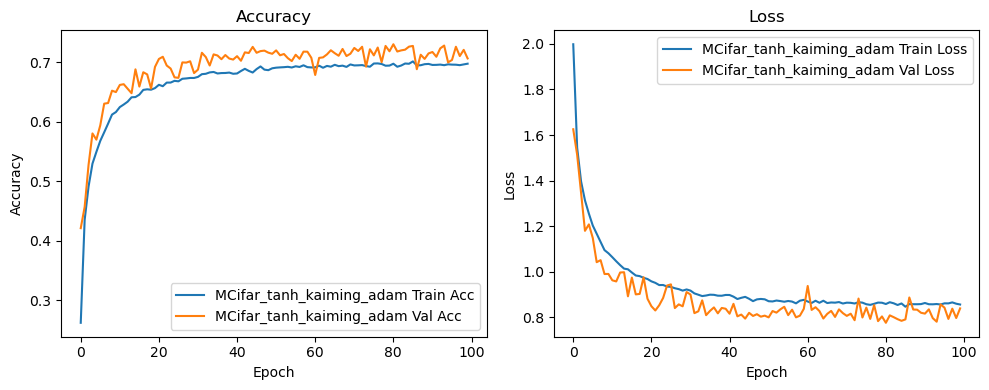

In [67]:
model_name = "MCifar_tanh_kaiming_adam"
model = create_cnn(activation_fn='tanh', initializer='he_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_kaiming_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.3106 - loss: 1.9336 - val_accuracy: 0.4419 - val_loss: 1.5458
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4376 - loss: 1.5502 - val_accuracy: 0.5267 - val_loss: 1.3162
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4908 - loss: 1.4110 - val_accuracy: 0.5267 - val_loss: 1.3676
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5303 - loss: 1.3140 - val_accuracy: 0.5630 - val_loss: 1.2396
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5502 - loss: 1.2538 - val_accuracy: 0.6118 - val_loss: 1.1024
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5703 - loss: 1.2078 - val_accuracy: 0.6110 - val_loss: 1.0933
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5806 - loss: 1.1715 - val_accuracy: 0.6184 - val_loss: 1.0893
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 2

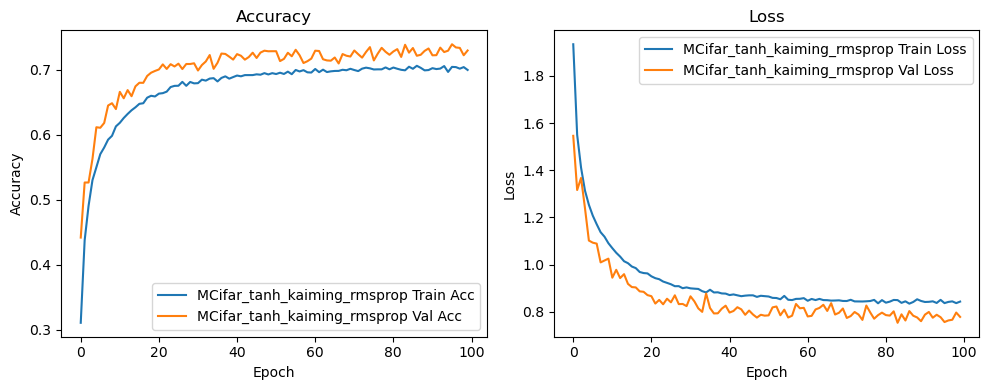

In [68]:
model_name = "MCifar_tanh_kaiming_rmsprop"
model = create_cnn(activation_fn='tanh', initializer='he_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_random_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1761 - loss: 2.1955 - val_accuracy: 0.2158 - val_loss: 2.1202
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2535 - loss: 2.0324 - val_accuracy: 0.2667 - val_loss: 1.9911
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.3004 - loss: 1.9190 - val_accuracy: 0.1728 - val_loss: 2.3777
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3444 - loss: 1.8012 - val_accuracy: 0.2646 - val_loss: 2.0176
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3757 - loss: 1.7167 - val_accuracy: 0.3684 - val_loss: 1.7305
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3979 - loss: 1.6562 - val_accuracy: 0.4094 - val_loss: 1.6178
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4139 - loss: 1.6068 - val_accuracy: 0.3633 - val_loss: 1.7916
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/s

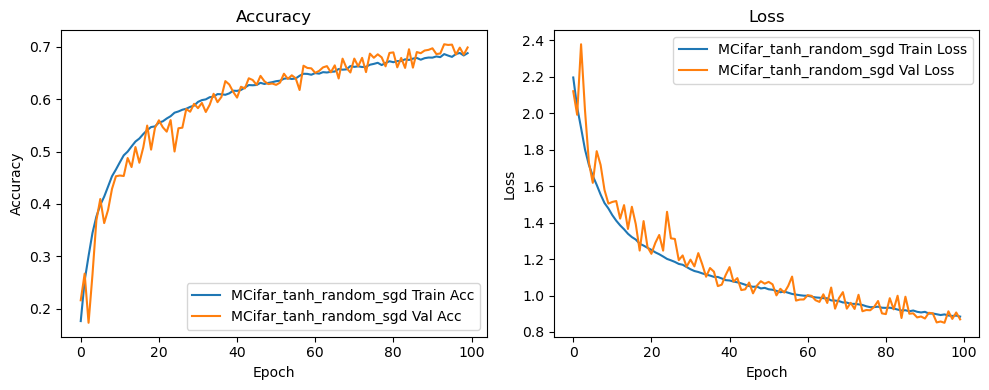

In [69]:
model_name = "MCifar_tanh_random_sgd"
model = create_cnn(activation_fn='tanh', initializer='random_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_random_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.3751 - loss: 1.7259 - val_accuracy: 0.4733 - val_loss: 1.4640
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4798 - loss: 1.4492 - val_accuracy: 0.4954 - val_loss: 1.4362
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5297 - loss: 1.3279 - val_accuracy: 0.5599 - val_loss: 1.2583
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5673 - loss: 1.2248 - val_accuracy: 0.6210 - val_loss: 1.0754
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5942 - loss: 1.1475 - val_accuracy: 0.6235 - val_loss: 1.0736
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6131 - loss: 1.0972 - val_accuracy: 0.6506 - val_loss: 1.0089
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6288 - loss: 1.0565 - val_accuracy: 0.6400 - val_loss: 1.0610
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms

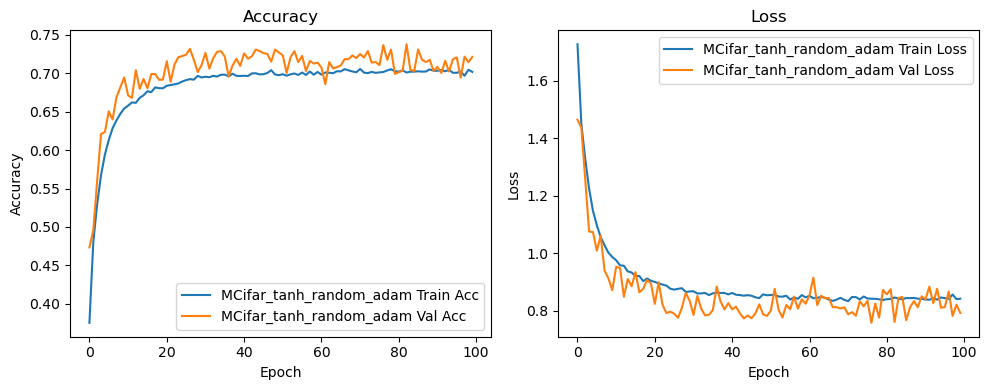

In [70]:
model_name = "MCifar_tanh_random_adam"
model = create_cnn(activation_fn='tanh', initializer='random_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_tanh_random_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.3444 - loss: 1.8056 - val_accuracy: 0.3678 - val_loss: 1.7669
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4646 - loss: 1.5085 - val_accuracy: 0.5202 - val_loss: 1.3349
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5128 - loss: 1.3672 - val_accuracy: 0.5270 - val_loss: 1.3474
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5504 - loss: 1.2699 - val_accuracy: 0.6072 - val_loss: 1.1201
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5793 - loss: 1.1910 - val_accuracy: 0.6277 - val_loss: 1.0844
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6032 - loss: 1.1359 - val_accuracy: 0.6650 - val_loss: 0.9613
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6197 - loss: 1.0887 - val_accuracy: 0.6510 - val_loss: 1.0067
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19

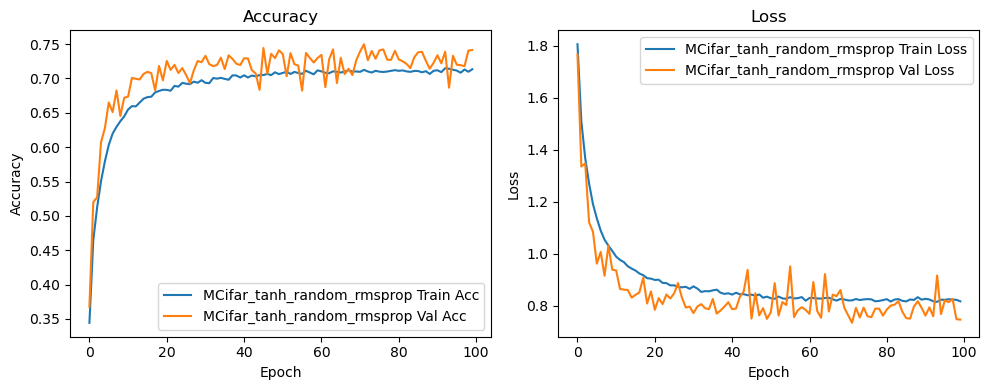

In [71]:
model_name = "MCifar_tanh_random_rmsprop"
model = create_cnn(activation_fn='tanh', initializer='random_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

C:\Users\kumar\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


--- Training MCifar_leaky_relu_xavier_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1005 - loss: 2.3034 - val_accuracy: 0.1079 - val_loss: 2.3012
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1249 - loss: 2.2915 - val_accuracy: 0.1971 - val_loss: 2.2797
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1925 - loss: 2.1889 - val_accuracy: 0.2100 - val_loss: 2.1677
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2293 - loss: 2.0884 - val_accuracy: 0.2098 - val_loss: 2.1261
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2438 - loss: 2.0369 - val_accuracy: 0.2582 - val_loss: 2.0147
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2567 - loss: 1.9960 - val_accuracy: 0.2555 - val_loss: 2.0023
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.2750 - loss: 1.9426 - val_accuracy: 0.2887 - val_loss: 1.9132
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s

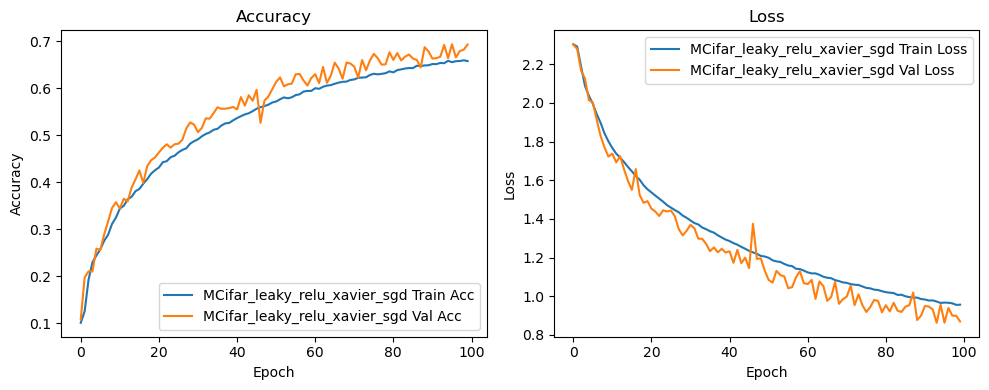

In [72]:
model_name = "MCifar_leaky_relu_xavier_sgd"
model = create_cnn(activation_fn='leaky_relu', initializer='glorot_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_xavier_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3000 - loss: 1.8687 - val_accuracy: 0.4113 - val_loss: 1.5719
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4469 - loss: 1.5009 - val_accuracy: 0.4934 - val_loss: 1.4232
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5067 - loss: 1.3517 - val_accuracy: 0.5530 - val_loss: 1.2497
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5428 - loss: 1.2662 - val_accuracy: 0.6028 - val_loss: 1.1040
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5678 - loss: 1.1932 - val_accuracy: 0.6011 - val_loss: 1.1099
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5921 - loss: 1.1328 - val_accuracy: 0.6518 - val_loss: 0.9804
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6088 - loss: 1.0928 - val_accuracy: 0.6104 - val_loss: 1.1187
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9

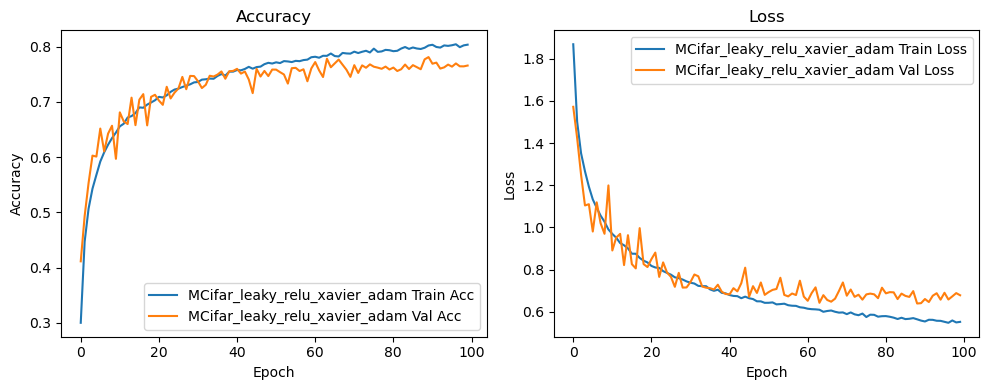

In [73]:
model_name = "MCifar_leaky_relu_xavier_adam"
model = create_cnn(activation_fn='leaky_relu', initializer='glorot_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_xavier_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2792 - loss: 1.9485 - val_accuracy: 0.3917 - val_loss: 1.6579
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4032 - loss: 1.6272 - val_accuracy: 0.4639 - val_loss: 1.4569
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4625 - loss: 1.4765 - val_accuracy: 0.4355 - val_loss: 1.6813
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5018 - loss: 1.3756 - val_accuracy: 0.5541 - val_loss: 1.2438
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5303 - loss: 1.2998 - val_accuracy: 0.5639 - val_loss: 1.2227
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5531 - loss: 1.2409 - val_accuracy: 0.6210 - val_loss: 1.0783
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5742 - loss: 1.1923 - val_accuracy: 0.6125 - val_loss: 1.0943
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━

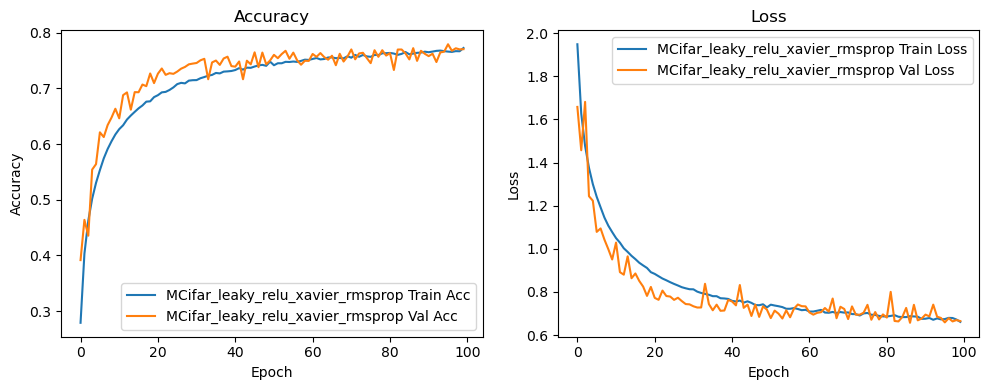

In [74]:
model_name = "MCifar_leaky_relu_xavier_rmsprop"
model = create_cnn(activation_fn='leaky_relu', initializer='glorot_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_kaiming_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1517 - loss: 2.2458 - val_accuracy: 0.2065 - val_loss: 2.2071
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2156 - loss: 2.1190 - val_accuracy: 0.2448 - val_loss: 2.0667
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2377 - loss: 2.0396 - val_accuracy: 0.2479 - val_loss: 2.0338
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2564 - loss: 1.9832 - val_accuracy: 0.2812 - val_loss: 1.9703
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2845 - loss: 1.9164 - val_accuracy: 0.2484 - val_loss: 2.0258
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3086 - loss: 1.8477 - val_accuracy: 0.2449 - val_loss: 2.0074
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3269 - loss: 1.7989 - val_accuracy: 0.2378 - val_loss: 2.0285
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s

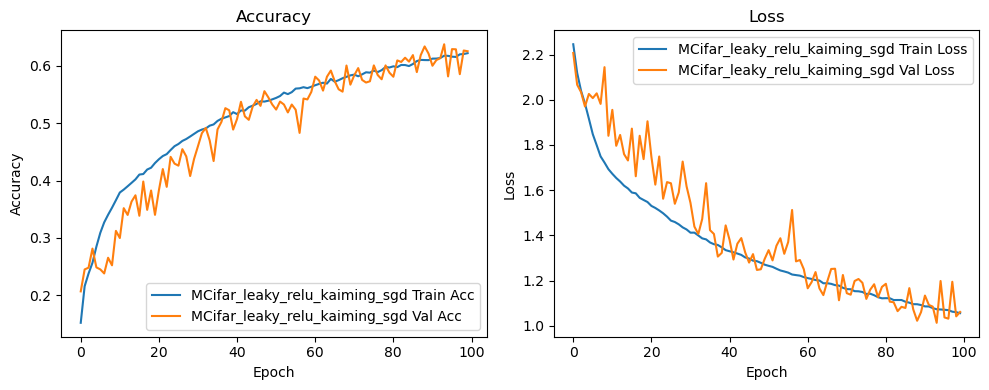

In [75]:
model_name = "MCifar_leaky_relu_kaiming_sgd"
model = create_cnn(activation_fn='leaky_relu', initializer='he_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_kaiming_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2389 - loss: 2.0414 - val_accuracy: 0.3697 - val_loss: 1.7034
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4063 - loss: 1.6116 - val_accuracy: 0.4402 - val_loss: 1.5738
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4712 - loss: 1.4508 - val_accuracy: 0.5042 - val_loss: 1.3887
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5117 - loss: 1.3462 - val_accuracy: 0.5370 - val_loss: 1.2909
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5389 - loss: 1.2744 - val_accuracy: 0.5414 - val_loss: 1.2796
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5638 - loss: 1.2075 - val_accuracy: 0.6079 - val_loss: 1.0950
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5804 - loss: 1.1631 - val_accuracy: 0.6087 - val_loss: 1.1075
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 

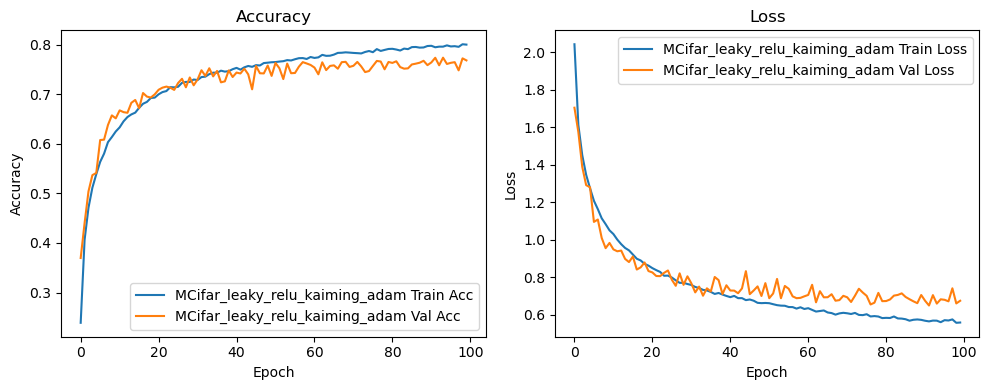

In [83]:
model_name = "MCifar_leaky_relu_kaiming_adam"
model = create_cnn(activation_fn='leaky_relu', initializer='he_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_kaiming_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.2844 - loss: 1.9391 - val_accuracy: 0.4077 - val_loss: 1.6429
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4053 - loss: 1.6319 - val_accuracy: 0.4572 - val_loss: 1.5531
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4561 - loss: 1.4870 - val_accuracy: 0.4930 - val_loss: 1.3828
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4988 - loss: 1.3823 - val_accuracy: 0.5146 - val_loss: 1.3436
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5291 - loss: 1.3073 - val_accuracy: 0.5732 - val_loss: 1.1730
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5511 - loss: 1.2505 - val_accuracy: 0.5492 - val_loss: 1.2718
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5650 - loss: 1.2102 - val_accuracy: 0.6308 - val_loss: 1.0414
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━

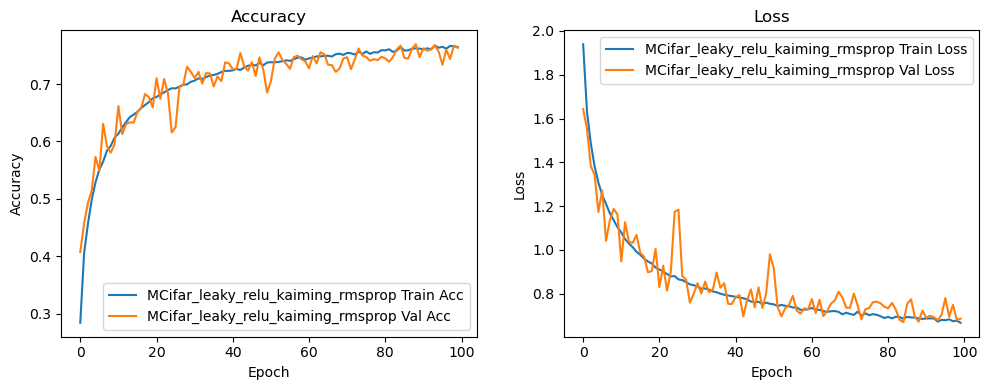

In [77]:
model_name = "MCifar_leaky_relu_kaiming_rmsprop"
model = create_cnn(activation_fn='leaky_relu', initializer='he_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_random_sgd ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.1056 - loss: 2.3021 - val_accuracy: 0.1337 - val_loss: 2.3017
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1183 - loss: 2.2994 - val_accuracy: 0.1373 - val_loss: 2.2977
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1527 - loss: 2.2750 - val_accuracy: 0.1667 - val_loss: 2.2423
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1813 - loss: 2.1812 - val_accuracy: 0.2120 - val_loss: 2.0963
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2044 - loss: 2.1041 - val_accuracy: 0.2295 - val_loss: 2.0869
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2305 - loss: 2.0430 - val_accuracy: 0.2748 - val_loss: 1.9571
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2445 - loss: 2.0030 - val_accuracy: 0.2690 - val_loss: 2.0107
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s

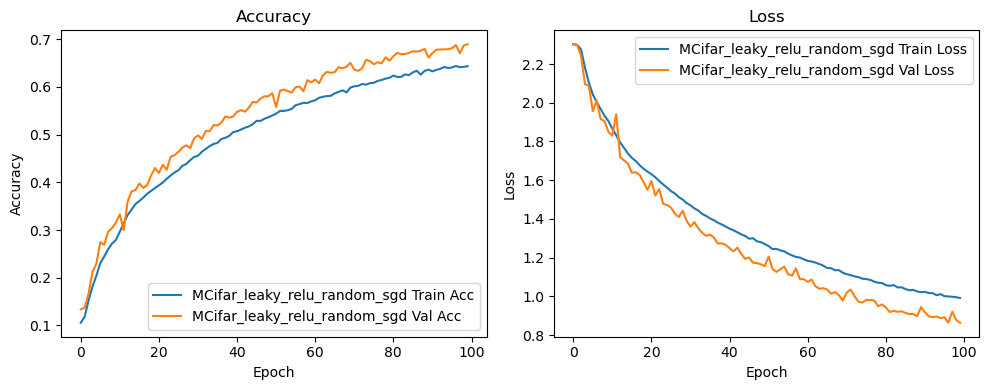

In [78]:
model_name = "MCifar_leaky_relu_random_sgd"
model = create_cnn(activation_fn='leaky_relu', initializer='random_normal', optimizer_str='sgd')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_random_adam ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3039 - loss: 1.8663 - val_accuracy: 0.4251 - val_loss: 1.5619
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4433 - loss: 1.5093 - val_accuracy: 0.5226 - val_loss: 1.3139
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4959 - loss: 1.3845 - val_accuracy: 0.5506 - val_loss: 1.2370
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5252 - loss: 1.3032 - val_accuracy: 0.5925 - val_loss: 1.1405
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5527 - loss: 1.2341 - val_accuracy: 0.6066 - val_loss: 1.0969
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5733 - loss: 1.1847 - val_accuracy: 0.6288 - val_loss: 1.0481
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5924 - loss: 1.1382 - val_accuracy: 0.6440 - val_loss: 0.9984
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9

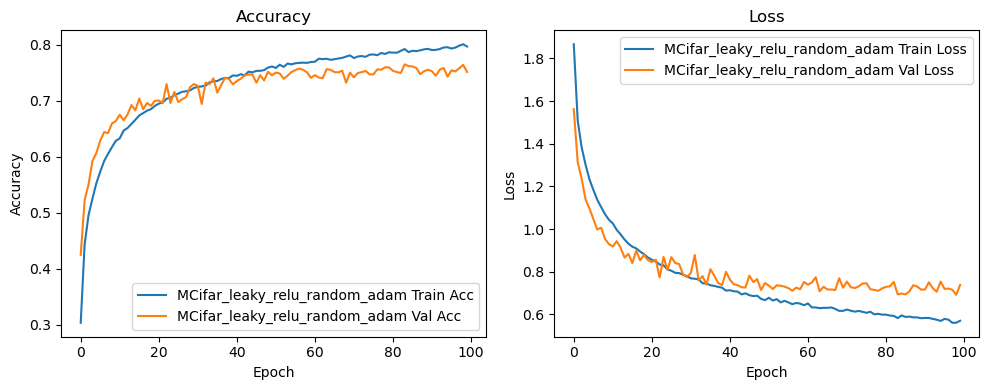

In [79]:
model_name = "MCifar_leaky_relu_random_adam"
model = create_cnn(activation_fn='leaky_relu', initializer='random_normal', optimizer_str='adam')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

--- Training MCifar_leaky_relu_random_rmsprop ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2251 - loss: 2.0745 - val_accuracy: 0.3049 - val_loss: 1.9447
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3695 - loss: 1.7150 - val_accuracy: 0.4572 - val_loss: 1.4973
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4315 - loss: 1.5460 - val_accuracy: 0.5033 - val_loss: 1.3633
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4696 - loss: 1.4508 - val_accuracy: 0.5168 - val_loss: 1.3269
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5020 - loss: 1.3692 - val_accuracy: 0.5437 - val_loss: 1.2561
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5308 - loss: 1.3014 - val_accuracy: 0.5815 - val_loss: 1.1493
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5503 - loss: 1.2473 - val_accuracy: 0.6134 - val_loss: 1.0948
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━

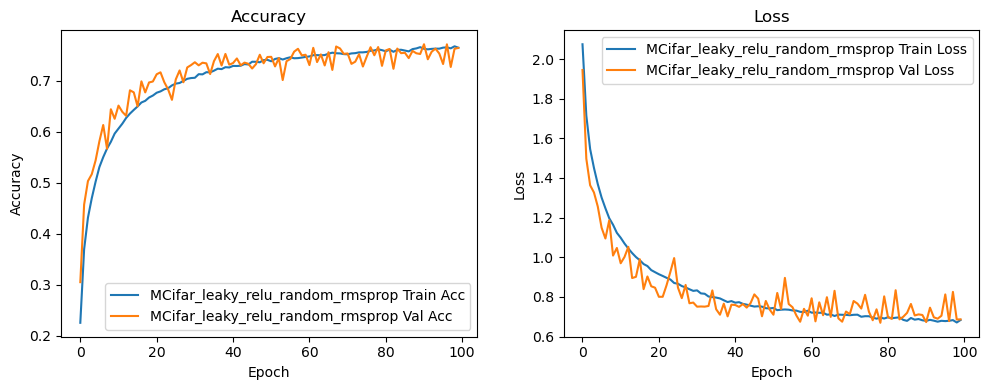

In [80]:
model_name = "MCifar_leaky_relu_random_rmsprop"
model = create_cnn(activation_fn='leaky_relu', initializer='random_normal', optimizer_str='rmsprop')
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

### Overall Best Model: Leaky Relu Activation + Xavier Initialization + RMSProp Optimizer

### Loading the ResNet Model

In [7]:
resnet_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(32, 32, 3)
)

for layer in resnet_model.layers:
    layer.trainable = False # Freeze most of the backbone at first
for layer in resnet_model.layers[-30:]:
    layer.trainable = True

### ResNet Configuration

In [8]:
inputs = layers.Input(shape=(32, 32, 3))
x = resnet_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)

outputs = layers.Dense(10, activation="softmax")(x)

### Model Training

--- Training MCifar_Resnet50 ---
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 151s 354ms/step - accuracy: 0.3944 - loss: 1.7543 - val_accuracy: 0.1092 - val_loss: 4.4213
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 138s 346ms/step - accuracy: 0.4767 - loss: 1.4845 - val_accuracy: 0.1099 - val_loss: 4.5888
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 139s 347ms/step - accuracy: 0.5137 - loss: 1.3746 - val_accuracy: 0.1065 - val_loss: 4.4664
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 139s 347ms/step - accuracy: 0.5393 - loss: 1.3019 - val_accuracy: 0.1090 - val_loss: 2.2960
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 142s 347ms/step - accuracy: 0.5634 - loss: 1.2369 - val_accuracy: 0.1015 - val_loss: 2.4972
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 139s 348ms/step - accuracy: 0.5820 - loss: 1.1731 - val_accuracy: 0.1415 - val_loss: 2.4963
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 139s 347ms/step - accuracy: 0.6047 - loss: 1.1126 - val_accuracy: 0.1097 - val_loss: 4.1121
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━

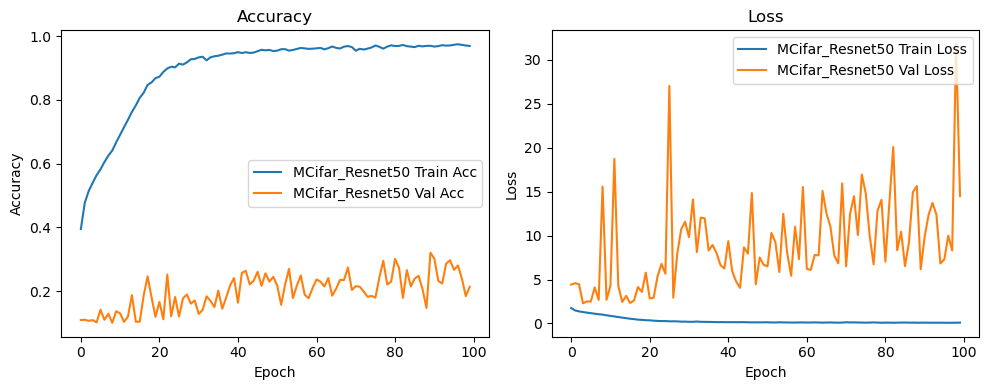

In [9]:
model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_name = "MCifar_Resnet"
history = train_cnn(model, X_train, y_train, X_val, y_val,model_name=model_name)
plot_history(history,model_name)

### Loading the Saved Models

In [7]:
model_1_scratch = load_model("MCifar_leaky_relu_xavier_rmsprop.keras")
model_2_resnet = load_model("MCifar_Resnet.keras")

### Predictions and Evaluations

In [11]:
def predict(model, X_test, y_test):
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0, average="weighted"),
        "Recall": recall_score(y_test, y_pred, zero_division=0, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0, average="weighted")
    }
    return metrics

In [12]:
metrics_scratch = predict(model_1_scratch, X_test, y_test)
metrics_resnet  = predict(model_2_resnet,  X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step


In [13]:
df = pd.DataFrame(
    [metrics_scratch, metrics_resnet],
    index=["Scratch CNN", "ResNet"]
)
df

,Accuracy,Precision,Recall,F1-Score
Scratch CNN,0.7641,0.772324,0.7641,0.762265
ResNet,0.2095,0.287790,0.2095,0.164162
